## SP/NP Basis Modelling

This Python project seeks to build some basic statistical models for predicting the SP/NP basis. We build two models: a linear regression model and a non-linear model (such as Random Forest or Neural Network). 
In this process, we do not consider the Date/Time column in our calculations since we are not treating this as a time series. 

## Outline
The workflow of our approach is as follows:
- Data Exploration and Pre-processing: Visualize the raw input data and observe patterns in correlation. Then, pre-process the data in a reasonable manner.
- Model Building: Construct baseline linear and non-linear models to predict the peak oil production rate.
- Evaluation: Use R-Squared and RMSE to evaluate the models and compare their performance.

Uses the input data v2 file.

In [140]:
# Import standard libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from typing import *

# Ignore warnings
warnings.simplefilter("ignore")

# Path to the training data
training_path = "./../Data/input data v2.xlsx"
model_save_path = "./../Saved Models/"
TARGET = "DA SPNP"

In [141]:
training_df = pd.read_excel(training_path)
training_df = training_df.dropna()
training_df = training_df.rename(columns={training_df.columns[-1]: "DA SPNP"})

training_df = training_df.drop(columns=['SP15 (SOLAR_FORECAST Latest) - NP15 (SOLAR_FORECAST Latest) Maximum'])
training_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3904 entries, 0 to 3903
Data columns (total 11 columns):
 #   Column                                                                             Non-Null Count  Dtype         
---  ------                                                                             --------------  -----         
 0   Date/Time                                                                          3904 non-null   datetime64[ns]
 1   CAISO (SOLAR_FORECAST) Average Latest Maximum                                      3904 non-null   float64       
 2   CAISO (WIND_FORECAST) Average Latest Maximum                                       3904 non-null   float64       
 3   SP15 (WIND_FORECAST Latest) - NP15 (WIND_FORECAST Latest) Maximum                  3904 non-null   float64       
 4   CAISO (PRT_FCAST_15D_LOAD_LATEST) Average Latest Maximum                           3904 non-null   int64         
 5   SP15 (PRT_FCAST_15D_LOAD_LATEST Latest) - NP15 (PRT_FCA

## Preliminary Visualization

<AxesSubplot:>

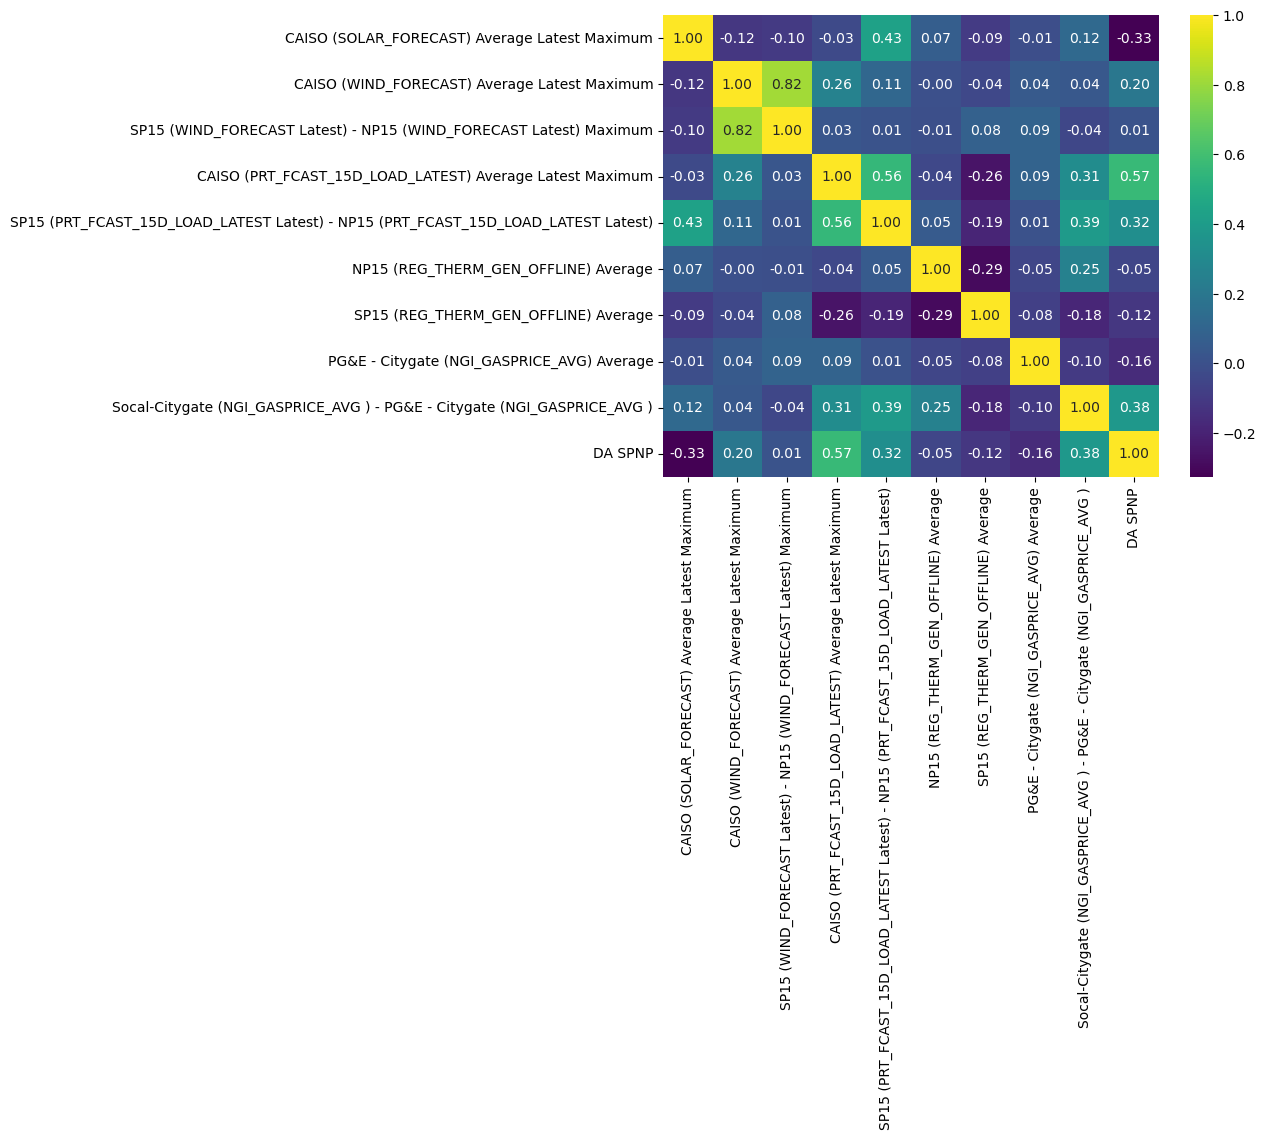

In [142]:
plt.figure(figsize=(8, 6))

# Selecting only the non-categorical variables from the DataFrame
non_categorical_data = training_df.select_dtypes(include=[np.number])
sns.heatmap(non_categorical_data.corr(), annot=True, fmt=".2f", cmap='viridis')

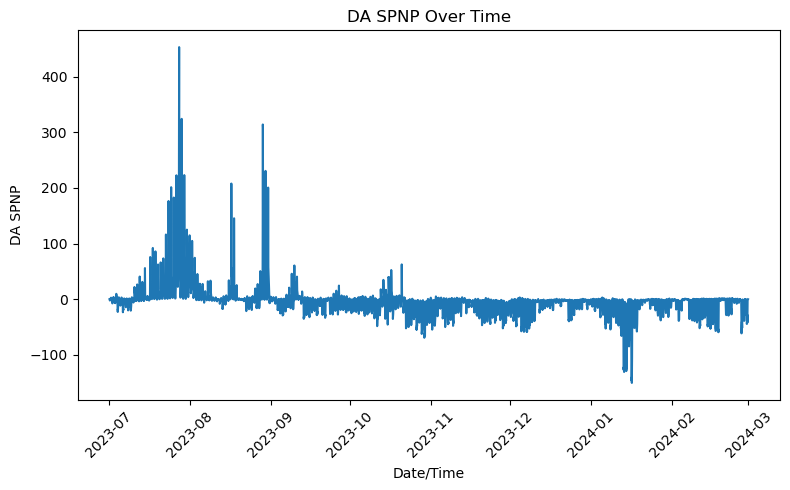

In [143]:
plt.figure(figsize=(8, 5))
sns.lineplot(data=training_df, x='Date/Time', y=TARGET)
plt.title('DA SPNP Over Time')
plt.xlabel('Date/Time')
plt.ylabel('DA SPNP')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [144]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Selecting the numeric columns (excluding the target variable 'DA SPNP' and date/time)
features = training_df.iloc[:, 1:10]

# Calculating VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = features.columns
vif_data["VIF"] = [variance_inflation_factor(features.values, i) for i in range(len(features.columns))]

vif_data

,feature,VIF
0,CAISO (SOLAR_FORECAST) Average Latest Maximum,3.141180
1,CAISO (WIND_FORECAST) Average Latest Maximum,8.879933
2,SP15 (WIND_FORECAST Latest) - NP15 (WIND_FOREC...,5.747025
3,CAISO (PRT_FCAST_15D_LOAD_LATEST) Average Late...,24.605920
4,SP15 (PRT_FCAST_15D_LOAD_LATEST Latest) - NP15...,9.918262
5,NP15 (REG_THERM_GEN_OFFLINE) Average,5.978912
6,SP15 (REG_THERM_GEN_OFFLINE) Average,2.939998
7,PG&E - Citygate (NGI_GASPRICE_AVG) Average,6.808181
8,Socal-Citygate (NGI_GASPRICE_AVG ) - PG&E - Ci...,1.306118


## Model Building

### Split into Training and Testing sets

In [145]:
from sklearn.model_selection import train_test_split

X = training_df.drop([TARGET], axis=1)
y = training_df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1234)
X_train = X_train.drop(columns=["Date/Time"], axis=1)
train_data = X_train.join(y_train)
test_data = X_test.join(y_test)

train_data.head()

,CAISO (SOLAR_FORECAST) Average Latest Maximum,CAISO (WIND_FORECAST) Average Latest Maximum,SP15 (WIND_FORECAST Latest) - NP15 (WIND_FORECAST Latest) Maximum,CAISO (PRT_FCAST_15D_LOAD_LATEST) Average Latest Maximum,SP15 (PRT_FCAST_15D_LOAD_LATEST Latest) - NP15 (PRT_FCAST_15D_LOAD_LATEST Latest),NP15 (REG_THERM_GEN_OFFLINE) Average,SP15 (REG_THERM_GEN_OFFLINE) Average,PG&E - Citygate (NGI_GASPRICE_AVG) Average,Socal-Citygate (NGI_GASPRICE_AVG ) - PG&E - Citygate (NGI_GASPRICE_AVG ),DA SPNP
142,5.63,3576.82,1421.84,28916,3714,503.93,1351.11,3.100,-0.640,3.28485
1537,2892.55,274.41,196.13,26041,1897,952.28,820.97,4.855,2.185,0.32682
406,13424.93,1508.48,213.52,35079,9571,1054.47,2520.81,5.390,1.185,10.45401
2274,9832.86,1203.48,223.20,24550,2264,1277.82,483.06,5.755,-0.250,-38.44018
3183,0.00,135.29,120.13,25077,2389,661.26,4738.61,17.005,-3.485,-7.67965


### Linear Regression

In [146]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

# Scale the input data
scaler = StandardScaler()
x_train, y_train = train_data.drop([TARGET], axis=1), train_data[TARGET]
X_train_s = scaler.fit_transform(x_train)

X_dates = test_data["Date/Time"]
X_test_no_date = X_test.drop(["Date/Time"], axis=1)
X_test_no_date_s = scaler.transform(X_test_no_date) 

# Fit a Lasso Regression model
alpha = 0.05
lasso_reg = Lasso(alpha=alpha)
lasso_reg.fit(X_train_s, y_train)

Lasso(alpha=0.05)

In [147]:
lasso_score = round(lasso_reg.score(X_test_no_date_s, y_test), 3)
lasso_score

0.609

In [148]:
from sklearn.metrics import mean_squared_error
y_pred = lasso_reg.predict(X_test_no_date_s)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Print the RMSE
print("Root Mean Squared Error (RMSE):", round(rmse, 3))

Root Mean Squared Error (RMSE): 16.379


In [149]:
X_dates

991    2023-08-31 22:00:00
302    2023-07-19 21:00:00
1101   2023-09-07 20:00:00
3790   2024-02-22 21:00:00
2237   2023-11-17 20:00:00
               ...        
1980   2023-11-01 19:00:00
1831   2023-10-23 14:00:00
1670   2023-10-13 13:00:00
2405   2023-11-28 12:00:00
2684   2023-12-15 19:00:00
Name: Date/Time, Length: 976, dtype: datetime64[ns]

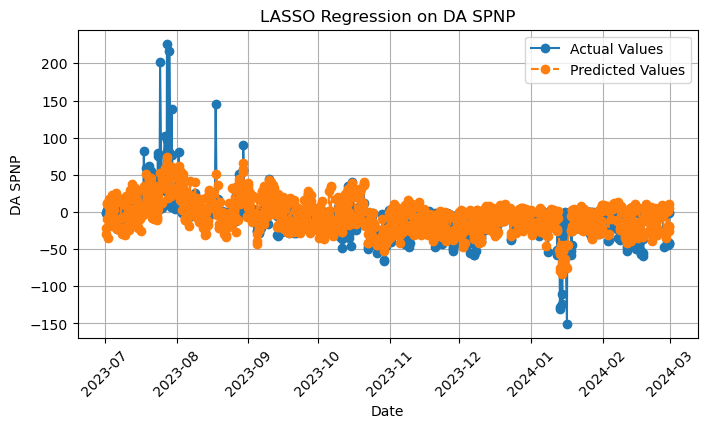

In [150]:
def plot_predictions(model, X_test, y_test, title):
    y_pred = model.predict(X_test)

    result_df = pd.DataFrame()
    result_df['Date'] = X_dates
    result_df['Actual'] = y_test
    result_df['Predicted'] = y_pred
    result_df = result_df.sort_values(by='Date')

    plt.figure(figsize=(8, 4))
    plt.plot(result_df['Date'], result_df['Actual'], label='Actual Values', marker='o', linestyle='-')
    plt.plot(result_df['Date'], result_df['Predicted'], label='Predicted Values', marker='o', linestyle='--')
    plt.xlabel('Date')
    plt.title(title)
    plt.ylabel(TARGET)
    plt.legend()
    plt.xticks(rotation=45) 
    plt.grid(True)

    return plt


plot_lasso = plot_predictions(lasso_reg, X_test_no_date_s, y_test, "LASSO Regression on " + TARGET)
plot_lasso.show()

### Random Forest Regression

In [151]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor()
forest.fit(X_train_s, y_train)

RandomForestRegressor()

In [152]:
forest_score = round(forest.score(X_test_no_date_s, y_test), 3)
forest_score

0.869

In [153]:
y_pred = forest.predict(X_test_no_date_s)
mse = mean_squared_error(y_test, y_pred)
f_rmse = np.sqrt(mse)

# Print the RMSE
print("Root Mean Squared Error (RMSE):", round(f_rmse, 3))

Root Mean Squared Error (RMSE): 9.464


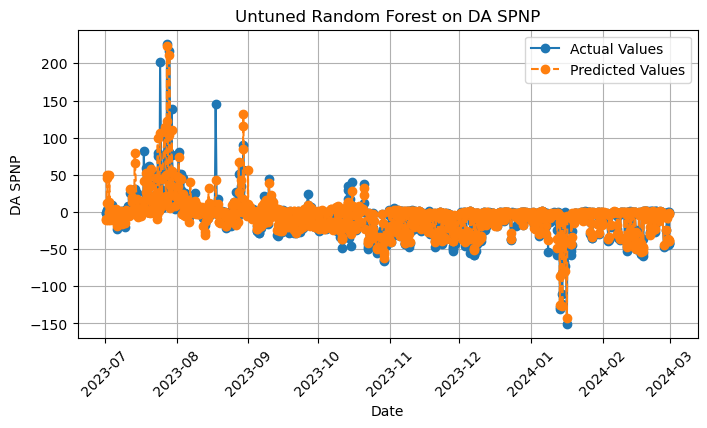

In [154]:
plot_rf = plot_predictions(forest, X_test_no_date_s, y_test, "Untuned Random Forest on " + TARGET)
plot_rf.show()

### Tuned Random Forest

In [155]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [100, 50],  
    "max_features": ['auto', 0.4, 0.6],  
    "max_depth": [None, 10, 20, 30],  
    "min_samples_split": [2, 5],  
    "min_samples_leaf": [1, 2],  
}

grid_search = GridSearchCV(forest, param_grid, n_jobs=-1, scoring="neg_mean_squared_error", return_train_score=True)
grid_search.fit(X_train_s, y_train)

GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'max_features': ['auto', 0.4, 0.6],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 50]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [156]:
best_forest = grid_search.best_estimator_
best_forest

RandomForestRegressor(max_depth=20, max_features=0.6)

In [157]:
best_forest_score = round(best_forest.score(X_test_no_date_s, y_test), 3)
best_forest_score

0.892

In [158]:
y_pred = best_forest.predict(X_test_no_date_s)
mse = mean_squared_error(y_test, y_pred)
bf_rmse = np.sqrt(mse)

# Print the RMSE
print("Root Mean Squared Error (RMSE):", round(bf_rmse, 3))

Root Mean Squared Error (RMSE): 8.621


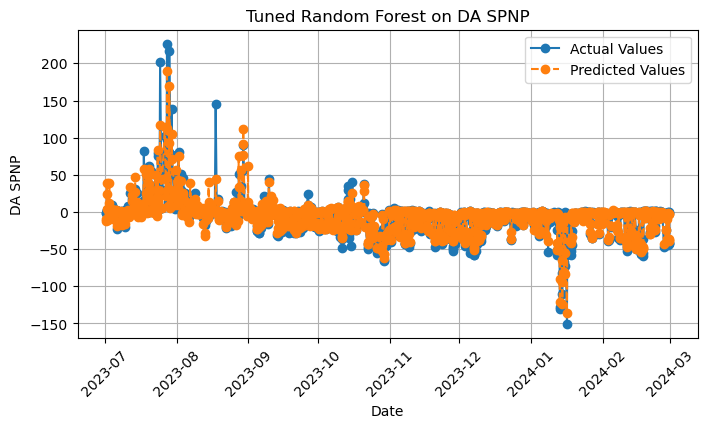

In [159]:
plot_best_rf = plot_predictions(best_forest, X_test_no_date_s, y_test, "Tuned Random Forest on " + TARGET)
plot_best_rf.show()

In [160]:
best_forest.feature_importances_

array([0.19574554, 0.04553263, 0.03210385, 0.32932408, 0.10771079,
       0.03862518, 0.04178674, 0.06674966, 0.14242153])

### Neural Network!

In [162]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

X_train_tensor = torch.tensor(X_train_s, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

class RegressionNN(nn.Module):
    def __init__(self):
        super(RegressionNN, self).__init__()
        self.fc1 = nn.Linear(X_train_s.shape[1], 64)  # Input layer
        self.fc2 = nn.Linear(64, 64)  
        self.fc3 = nn.Linear(64, 1) 

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  
        return x
    
model = RegressionNN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        optimizer.zero_grad()  
        outputs = model(inputs)  
        loss = criterion(outputs, targets)  
        loss.backward()  
        optimizer.step()
        
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 60.7332
Epoch [20/100], Loss: 107.1649
Epoch [30/100], Loss: 148.7772
Epoch [40/100], Loss: 190.7600
Epoch [50/100], Loss: 36.6321
Epoch [60/100], Loss: 210.0810
Epoch [70/100], Loss: 91.6635
Epoch [80/100], Loss: 67.5295
Epoch [90/100], Loss: 109.0799
Epoch [100/100], Loss: 27.4259


In [163]:
from sklearn.metrics import r2_score
model.eval()  
with torch.no_grad():
    predictions = model(torch.Tensor(X_test_no_date_s))

predictions_np = predictions.flatten()  

mse = mean_squared_error(y_test, predictions_np)
rmse = np.sqrt(mse)

print("Root Mean Squared Error (RMSE):", round(rmse, 3))
r2 = r2_score(y_test, predictions_np.numpy())

print("R^2 Score:", round(r2, 3))

Root Mean Squared Error (RMSE): 10.202
R^2 Score: 0.848


### Save the Tuned Random Forest and Neural Networks to Pickle files

In [164]:
import pickle

best_model = best_forest if bf_rmse < f_rmse else forest

with open(model_save_path + "random_forest_model_v2.pkl", 'wb') as f:
    pickle.dump(best_forest, f)

torch.save(model.state_dict(), model_save_path + "regression_nn_model_v2.pth")

# Save the scaler to a pickle file so we can scale the new custom data the same way as our training data
with open(model_save_path + 'scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)
